
#  American Option FD Valuation — Validation Notebook

 This notebook:
 1. Imports all required packages for `VanillaOptionPricerTest` 
 2. Defines inputs and prints a full trade summary
 3. Runs the valuation: price + greeks.
 4. Shows **Front Arena** (FIS) results with a valuation comparison table with absolute and % differences.
 5. Plots price convergence.



In [1]:
%pip install --upgrade pip
%pip install numpy pandas matplotlib QuantLib ipykernel jinja2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# 1) Imports & environment checks

import os, sys
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import QuantLib as ql

# Ensure we can import the local pricer module (adjust path if needed)
HERE = os.getcwd()
if HERE not in sys.path:
    sys.path.append(HERE)

from vanilla_option_pricer_test import VanillaOptionPricerTest  

plt.rcParams["figure.figsize"] = (9.5, 5.5)
plt.rcParams["axes.grid"] = True

print("Environment OK: QuantLib, pandas, numpy, matplotlib loaded; pricer imported.")


Environment OK: QuantLib, pandas, numpy, matplotlib loaded; pricer imported.


In [6]:
# 2) Inputs & trade setup

calendar = ql.SouthAfrica()
day_count = ql.Actual365Fixed()

valuation  = ql.Date(28, 7, 2025)
expiry     = ql.Date(28, 8, 2025)

S0 = 176.39
K = 170.00
r = 0.070538282720     
q = 0             
sigma = 0.296783211249       

option_type = "put"      
exercise_type = "American" 
settlement_type = "cash"
trade_number = 201870944     

side   = "buy"
contracts = 1
contract_multiplier = 1

option_spot_days = 0   
option_settlement_days = 0   
underlying_spot_days = 3   

time_steps_list: List[int] = [40, 60, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]

front_arena: Dict[str, float] = {
    "Price"         : 2.9846891127,
    "Delta"         : -0.2978815582,
    "Gamma"         : 0.0230742255,
    "Vega"          : 0.1778185529,
    "Theta (Annual)": -27.96921280,
    "Theta (Daily)" : -0.07662798
}

pricer = VanillaOptionPricerTest(
    spot_price=S0,
    strike_price=K,
    risk_free_rate=r,
    volatility=sigma,
    dividend_yield=q,
    valuation_date=valuation,
    maturity_date=expiry,
    contracts=contracts,
    contract_multiplier=contract_multiplier,
    side=side,
    option_type=option_type,
    exercise_type=exercise_type,
    option_spot_days=option_spot_days,
    option_settlement_days=option_settlement_days,
    underlying_spot_days=underlying_spot_days,
    settlement_type=settlement_type,
    calendar=calendar,
    day_counter=day_count,
    trade_number=trade_number
)

print("=== Trade Summary ===")
print(f"Trade Number           : {trade_number}")
print(f"Type / Exercise        : {option_type} / {exercise_type} ({settlement_type})")
print(f"Position               : {side}")
print(f"Contracts              : {contracts}")
print(f"Contract Multiplier    : {contract_multiplier}")
print(f"S0, K                  : {S0:.6f}, {K:.6f}")
print(f"r, q, sigma            : {r:.8f}, {q:.8f}, {sigma:.8f}")
print(f"Valuation, Expiry      : {valuation.ISO()}, {expiry.ISO()}")
print(f"Option spot / settle   : S={option_spot_days}bd, E={option_settlement_days}bd")
print(f"Underlying spot (U)    : U={underlying_spot_days}bd")

# If your class exposes these attributes (it does in the version you shared), print them:
try:
    print(f"discount_start → end   : {pricer.discount_start.ISO()} → {pricer.discount_end.ISO()} "
          f"({day_count.yearFraction(pricer.discount_start, pricer.discount_end):.8f}y)")
    print(f"carry_start → end      : {pricer.carry_start.ISO()} → {pricer.carry_end.ISO()} "
          f"({day_count.yearFraction(pricer.carry_start, pricer.carry_end):.8f}y)")
except Exception as e:
    print("(Note) Could not access carry/discount window attributes:", e)


=== Trade Summary ===
Trade Number           : 201870944
Type / Exercise        : put / American (cash)
Position               : buy
Contracts              : 1
Contract Multiplier    : 1
S0, K                  : 176.390000, 170.000000
r, q, sigma            : 0.07053828, 0.00000000, 0.29678321
Valuation, Expiry      : 2025-07-28, 2025-08-28
Option spot / settle   : S=0bd, E=0bd
Underlying spot (U)    : U=3bd
discount_start → end   : 2025-07-28 → 2025-08-28 (0.08493151y)
carry_start → end      : 2025-07-31 → 2025-09-02 (0.09041096y)


In [7]:
# 3) Valuation: price & greeks, plus comparison to Front Arena

price_map = pricer.batch_price(time_steps_list)

print("\n=== Price Convergence (Richardson)===")
for n, p in price_map.items():
    print(f"{n:4d} → {p:.10f}")

N_star = time_steps_list[1]
model_price = price_map[N_star]

greeks = pricer.calculate_greeks(1000)

index = ["Price", "Delta", "Gamma", "Vega", "Theta (Annual)", "Theta (Daily)"]
my_values = {
    "Price"         : model_price,
    "Delta"         : greeks.get("Delta", np.nan),
    "Gamma"         : greeks.get("Gamma", np.nan),
    "Vega"          : greeks.get("Vega", np.nan),
    "Theta (Annual)": greeks.get("Theta (Annual)", np.nan),
    "Theta (Daily)" : greeks.get("Theta (Daily)", np.nan),
}

# Comparison DataFrame
def pct_diff(model_val: float, fa_val: float) -> float:
    if fa_val is None or np.isnan(fa_val) or fa_val == 0.0:
        return np.nan
    return abs(model_val - fa_val) / abs(fa_val) * 100.0

rows = []
for key in index:
    m = my_values.get(key, np.nan)
    f = front_arena.get(key, np.nan)
    rows.append({
        "Metric": key,
        "Model": m,
        "FrontArena": f,
        "AbsDiff": (abs(m - f) if not (np.isnan(m) or np.isnan(f)) else np.nan),
        "PctDiff(%)": pct_diff(m, f)
    })

df_compare = pd.DataFrame(rows).set_index("Metric")
display(df_compare.style.format({
    "Model": "{:,.10f}",
    "FrontArena": "{:,.10f}",
    "AbsDiff": "{:,.10f}",
    "PctDiff(%)": "{:,.6f}"
}))

print("\n=== Headline Results (N = {}) ===".format(N_star))
print(f"Trade Number           : {trade_number}")
for k in index:
    mv = my_values[k]
    fv = front_arena.get(k, np.nan)
    ad = abs(mv - fv) if not (np.isnan(mv) or np.isnan(fv)) else np.nan
    pdiff = pct_diff(mv, fv)
    print(f"{k:<15} | Model: {mv: .10f} | FA: {fv: .10f} | AbsDiff: {ad: .10f} | %Diff: {pdiff: .6f}")



=== Price Convergence (Richardson)===
  40 → 3.0023756352
  60 → 3.0043237087
 100 → 3.0050057945
 150 → 3.0053302510
 200 → 3.0054868416
 250 → 3.0055785626
 300 → 3.0056386032
 350 → 3.0056808484
 400 → 3.0057121236
 450 → 3.0057361880
 500 → 3.0057552440
1000 → 3.0058384762


,Model,FrontArena,AbsDiff,PctDiff(%)
Metric,,,,
Price,3.0043237087,2.9846891127,0.0196345960,0.657844
Delta,-0.2993338309,-0.2978815582,0.0014522727,0.487534
Gamma,0.0231172378,0.0230742255,0.0000430123,0.186409
Vega,0.1781744214,0.1778185529,0.0003558685,0.200130
Theta (Annual),-27.9422012306,-27.9692128000,0.0270115694,0.096576
Theta (Daily),-0.0765539760,-0.0766279800,0.0000740040,0.096576



=== Headline Results (N = 60) ===
Trade Number           : 201870944
Price           | Model:  3.0043237087 | FA:  2.9846891127 | AbsDiff:  0.0196345960 | %Diff:  0.657844
Delta           | Model: -0.2993338309 | FA: -0.2978815582 | AbsDiff:  0.0014522727 | %Diff:  0.487534
Gamma           | Model:  0.0231172378 | FA:  0.0230742255 | AbsDiff:  0.0000430123 | %Diff:  0.186409
Vega            | Model:  0.1781744214 | FA:  0.1778185529 | AbsDiff:  0.0003558685 | %Diff:  0.200130
Theta (Annual)  | Model: -27.9422012306 | FA: -27.9692128000 | AbsDiff:  0.0270115694 | %Diff:  0.096576
Theta (Daily)   | Model: -0.0765539760 | FA: -0.0766279800 | AbsDiff:  0.0000740040 | %Diff:  0.096576


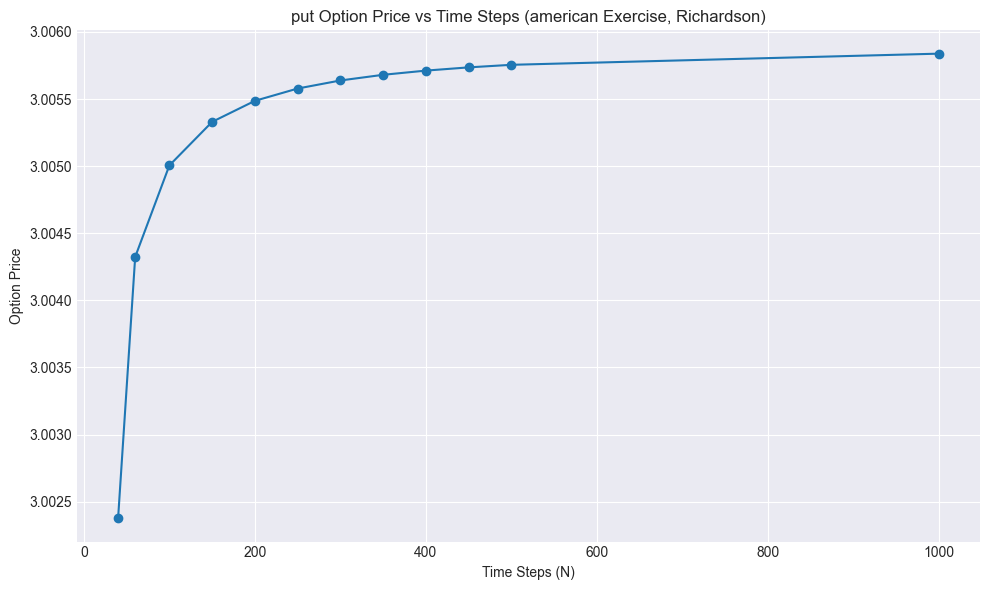

In [8]:
# 4) Plot price convergence

pricer.plot_price_convergence(time_steps_list)


# Export: Front Arena vs Model comparison → CSV


In [9]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

try:
    trade_number
except NameError:
    trade_number = "UNKNOWN"

try:
    from zoneinfo import ZoneInfo  # Py 3.9+
    ts_dt = datetime.now(ZoneInfo("Africa/Johannesburg"))
except Exception:
    ts_dt = datetime.now()
ts = ts_dt.strftime("%Y-%m-%d %H%M%S")

exercise_tag = str(exercise_type).capitalize().strip()
option_tag   = str(option_type).capitalize().strip()

safe_trade_number = "".join(ch for ch in str(trade_number) if ch.isalnum() or ch in ("-", "_"))

filename = (
    f"Front Arena Finite Difference {exercise_tag} {option_tag} "
    f"option Valuation Comparison {safe_trade_number} {ts}.csv"
)
out_path = os.path.join(os.getcwd(), filename)

if "df_compare" not in globals():
    raise RuntimeError("df_compare not found. Run the valuation cell that builds df_compare first.")

df_out = df_compare.reset_index().copy()

def fmt_num(x, fmt):
    return "" if (x is None or (isinstance(x, float) and np.isnan(x))) else fmt.format(x)

format_map = {
    "Model": "{:,.10f}",
    "FrontArena": "{:,.10f}",
    "AbsDiff": "{:,.10f}",
}
for col, fmt in format_map.items():
    if col in df_out.columns:
        df_out[col] = df_out[col].apply(lambda v, _f=fmt: fmt_num(v, _f))

if "PctDiff(%)" in df_out.columns:
    df_out["PctDiff(%)"] = df_out["PctDiff(%)"].apply(
        lambda x: "" if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{x:,.4f}%"
    )

df_out.to_csv(
    out_path,
    index=False,
    encoding="utf-8-sig",
    lineterminator="\n"
)

print(f"Saved Rainbow-friendly CSV → {out_path}")
print("Open this file in VS Code with the Rainbow CSV extension for aligned, colorized columns.")


Saved Rainbow-friendly CSV → c:\Investec Model Validation_github\derivatives-pricing\finite_difference_methodology\Front Arena Finite Difference American Put option Valuation Comparison 201870944 2025-08-28 093553.csv
Open this file in VS Code with the Rainbow CSV extension for aligned, colorized columns.
